# Processing your Eclipse Photo with SunPy

Requirements
* Python 3
* matplotlib
* scipy
* sunpy >= 0.8
* skimage
* exifread
* astropy

In [1]:
from datetime import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import scipy.ndimage as ndimage
from skimage.transform import hough_circle, hough_circle_peaks

import astropy.wcs
from astropy.coordinates import EarthLocation, SkyCoord
import astropy.units as u

import sunpy
import sunpy.map
import sunpy.coordinates

import exifread # to read information from the image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
sunpy.system_info()

 SunPy Installation Information


###########
 General
###########
Time : Monday, 27. November 2017 09:34PM UT
System : Darwin
Processor : i386
Arch : 64bit
SunPy : 0.8.2
SunPy_git : 16ddebd171961bde434d9133c489d9c6e0a1f97a
OS: Mac OS X 10.12.6 (i386)


###########
 Required Libraries 
###########
Python: 3.6.3
NumPy: 1.13.3
SciPy: 0.19.1
matplotlib: 2.1.0
Astropy: 2.0.2
Pandas: 0.21.0


###########
 Recommended Libraries 
###########
beautifulsoup: 4.6.0
PyQt: NOT INSTALLED
SUDS: 0.6
Sqlalchemy: 1.1.13
Requests: 2.18.4


Replace the following with your photo filename. Here we are using an eclipse photo originally taken by Henke Bril taken in Salloum, Egypt on March 29, 2006. We've hacked the EXIF info to make it seem like it was taken for this eclipse. We will update this with a real 2017 Eclipse photo as soon as we have one!

In [3]:
f = 'total_solar_eclipse2017.jpg'

## First let's try to get some metadata from the file

In [4]:
tags = exifread.process_file(open(f, 'rb'))

In [5]:
# the following functions will help us get GPS data from the EXIF data if it exists
def _convert_to_degress(value):
    """
    Helper function to convert the GPS coordinates stored in the EXIF to degress in float format
    :param value:
    :type value: exifread.utils.Ratio
    :rtype: float
    """
    d = float(value.values[0].num) / float(value.values[0].den)
    m = float(value.values[1].num) / float(value.values[1].den)
    s = float(value.values[2].num) / float(value.values[2].den)

    return d + (m / 60.0) + (s / 3600.0)
    
def get_exif_location(exif_data):
    """
    Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)
    """
    lat = None
    lon = None

    gps_latitude = exif_data.get('GPS GPSLatitude', None)
    gps_latitude_ref = exif_data.get('GPS GPSLatitudeRef', None)
    gps_longitude = exif_data.get('GPS GPSLongitude', None)
    gps_longitude_ref = exif_data.get('GPS GPSLongitudeRef', None)

    if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
        lat = _convert_to_degress(gps_latitude)
        if gps_latitude_ref.values[0] != 'N':
            lat = 0 - lat

        lon = _convert_to_degress(gps_longitude)
        if gps_longitude_ref.values[0] != 'E':
            lon = 0 - lon

    return lat, lon

In [6]:
if "EXIF ExposureTime" in tags:
    exposure_tag = tags['EXIF ExposureTime']
    exposure_time = exposure_tag.values[0].num / exposure_tag.values[0].den * u.s
    print("Exposure time of {0} found!".format(exposure_time))
if "Image Artist" in tags:
    author_str = tags['Image Artist'].values
    print("Author name of {0} found!".format(author_str))
if "EXIF DateTimeOriginal" in tags:
    datetime_str = tags['EXIF DateTimeOriginal'].values.replace(' ', ':').split(':')
    time = datetime(int(datetime_str[0]), int(datetime_str[1]), 
                    int(datetime_str[2]), int(datetime_str[3]),
                    int(datetime_str[4]), int(datetime_str[5]))
    print("Image time of {0} found!".format(str(time)))
if "Image Model" in tags:
    camera_model_str = tags['Image Model'].values
    print("Camera model of {0} found!".format(camera_model_str))
lat, lon = get_exif_location(tags)
if ((lat != None) and (lon != None)):
    gps = [lat, lon] * u.deg
    print("Found GPS location of {0}, {1} found!".format(gps[0], gps[1]))

Exposure time of 0.016666666666666666 s found!
Author name of Steven D. Christe found!
Image time of 2017-08-21 11:27:13 found!
Camera model of Canon EOS 70D found!
Found GPS location of 44.30287222222222 deg, -116.08796944444444 deg found!


The following variables need to be defined. If they were not found in the EXIF data please define them below

In [7]:
# exposure_time = 0.1 * u.s
# camera_model_str = 'Canon 70D'
# author_str = 'Julius Berkowski'
time = datetime(2017, 8, 21, 17, 27, 13) # don't forget to convert your time to UTC!
#gps = [44.37197, -116.87393] * u.deg # latitude, longitude of Mann Creek, Idaho

## Read in the image data

In [8]:
# read in the image and flip it so that it's correct
im_rgb = np.flipud(matplotlib.image.imread(f))
# remove color info
im = np.average(im_rgb, axis=2)

# Get info from the image

We need the following information from the image
* the location of the center of the Sun/Moon and 
* the scale of the picture which we get from the size of the Sun/Moon in pixels

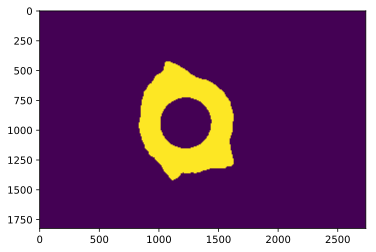

In [9]:
blur_im = ndimage.gaussian_filter(im, 8)
mask = blur_im > blur_im.mean() * 3
plt.imshow(mask)

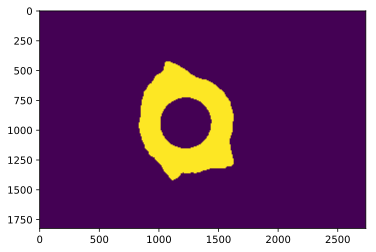

In [10]:
label_im, nb_labels = ndimage.label(mask)
plt.imshow(label_im)

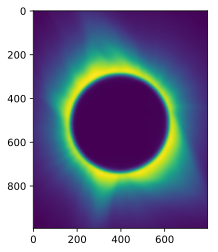

In [11]:
slice_x, slice_y = ndimage.find_objects(label_im==1)[0]
roi = blur_im[slice_x, slice_y]
plt.imshow(roi)

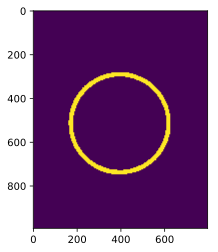

In [12]:
sx = ndimage.sobel(roi, axis=0, mode='constant')
sy = ndimage.sobel(roi, axis=1, mode='constant')
sob = np.hypot(sx, sy)
plt.imshow(sob > (sob.mean() * 5))

In [13]:
from skimage.transform import hough_circle, hough_circle_peaks

hough_radii = np.arange(np.floor(np.mean(sob.shape)/4), np.ceil(np.mean(sob.shape)/2), 10)
hough_res = hough_circle(sob > (sob.mean() * 5), hough_radii)

# Select the most prominent circle
accums, cy, cx, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
print(cx, cy, radii)

[514] [393] [ 223.]


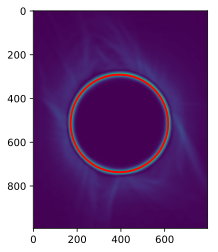

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
circ = Circle([cy, cx], radius=radii, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(sob)
ax.add_patch(circ)
plt.show()

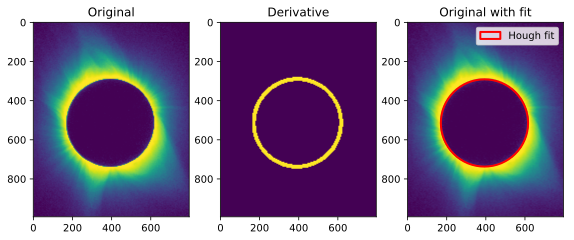

In [15]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(9.5, 6))
ax[0].imshow(im[slice_x, slice_y])
ax[0].set_title('Original')
ax[1].imshow(sob > (sob.mean() * 5))
ax[1].set_title('Derivative')
circ = Circle([cy, cx], radius=radii, facecolor='none', edgecolor='red', linewidth=2, label='Hough fit')
ax[2].imshow(im[slice_x, slice_y])
ax[2].add_patch(circ)
ax[2].set_title('Original with fit')
plt.legend()

Now let's check it with the original image

[ 223.] pix


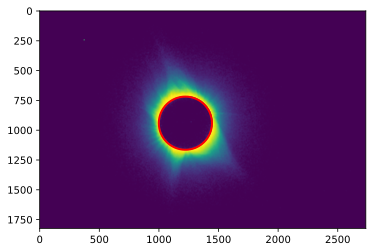

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
fudge_shift_x = 0 * u.pix # update this in case the fit needs to be shifted in x
fudge_shift_y = 0 * u.pix # update this in case the fit needs to be shifted in y
im_cx = (cx + slice_x.start) * u.pix + fudge_shift_x
im_cy = (cy + slice_y.start) * u.pix + fudge_shift_y
im_radius = radii * u.pix
print(im_radius)
circ = Circle([im_cy.value, im_cx.value], radius=im_radius.value, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(im)
ax.add_patch(circ)
plt.show()

In [17]:
masked = im.copy()
masked[slice_x, slice_y] = masked.min()

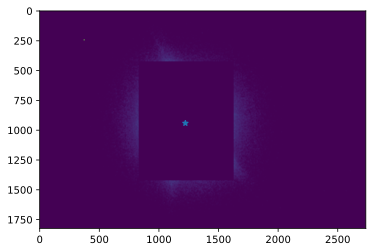

In [18]:
plt.imshow(masked)
plt.plot(im_cy, im_cx, '*')
circ = Circle([im_cy.value, im_cx.value], radius=im_radius.value, facecolor='none', edgecolor='red', linewidth=2)

# Getting information about the Sun

Let's now get the distance between the Earth and the Sun at the time the photo was taken

In [19]:
dsun = sunpy.coordinates.get_sunearth_distance(time.isoformat())
print(dsun)

1.011546589067374 AU


The size of the Sun in the sky is then

In [20]:
rsun_obs = np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec')
print(rsun_obs)

948.0099660006414 arcsec


The image plate scale is then

In [21]:
plate_scale = rsun_obs / im_radius
print(plate_scale)

[ 4.25116577] arcsec / pix


We also need the solar rotation angle

In [22]:
loc = EarthLocation(lat=gps[0], lon=gps[1])
fudge_angle = 0.0 * u.deg # update this in case your camera was not perfectly level.
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, time) + fudge_angle

In [23]:
hgln_obs = 0 * u.deg # sunpy.coordinates.get_sun_L0(time)
hglt_obs = sunpy.coordinates.get_sun_B0(time)
print("{0} {1}".format(hglt_obs, hgln_obs))

6.9281560172684085 deg 0.0 deg


# Define your WCS object and header

In [24]:
w = astropy.wcs.WCS(naxis=2)
w.wcs.crpix = [im_cy[0].value, im_cx[0].value]
w.wcs.cdelt = np.ones(2) * plate_scale.to('arcsec/pix').value
w.wcs.crval = [0, 0]
w.wcs.ctype = ['TAN', 'TAN']
w.wcs.cunit = ['arcsec', 'arcsec']
w.wcs.dateobs = time.isoformat()

Using this object we can now create the sunpy map header

In [25]:
header = dict(w.to_header())
header.update({'CROTA2': solar_rotation_angle.to('deg').value})
header.update({'DSUN_OBS': dsun.to('m').value})
header.update({'HGLN_OBS': hgln_obs.to('deg').value})
header.update({'HGLT_OBS': hglt_obs.to('deg').value})
header.update({'CTYPE1': 'HPLN-TAN'})
header.update({'CTYPE2': 'HPLT-TAN'})
header.update({'RSUN': dsun.to('m').value})
header.update({'RSUN_OBS': np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec').value})

Now add metadata about the photograph.

In [26]:
header.update({'AUTHOR': author_str})
header.update({'EXPTIME': exposure_time.to('s').value})
header.update({'TELESCOP': camera_model_str})
header.update({'INSTRUME': camera_model_str})
header.update({'DETECTOR': camera_model_str})

In [27]:
header

{'AUTHOR': 'Steven D. Christe',
 'CDELT1': 4.251165766819,
 'CDELT2': 4.251165766819,
 'CROTA2': -54.32892577666654,
 'CRPIX1': 1222.0,
 'CRPIX2': 941.0,
 'CRVAL1': 0.0,
 'CRVAL2': 0.0,
 'CTYPE1': 'HPLN-TAN',
 'CTYPE2': 'HPLT-TAN',
 'CUNIT1': 'arcsec',
 'CUNIT2': 'arcsec',
 'DATE-OBS': '2017-08-21T17:27:13',
 'DETECTOR': 'Canon EOS 70D',
 'DSUN_OBS': 151325215838.32706,
 'EXPTIME': 0.016666666666666666,
 'HGLN_OBS': 0.0,
 'HGLT_OBS': 6.9281560172684085,
 'INSTRUME': 'Canon EOS 70D',
 'LATPOLE': 90.0,
 'RSUN': 151325215838.32706,
 'RSUN_OBS': 948.0099660006414,
 'TELESCOP': 'Canon EOS 70D',
 'WCSAXES': 2}

# Creating SunPy Map

In [28]:
m = sunpy.map.Map((im, header))
m

SunPy Map
---------
Observatory:		 Canon EOS 70D
Instrument:		 Canon EOS 70D
Detector:		 Canon EOS 70D
Measurement:		 0.0
Wavelength:		 0.0
Observation Date:	 2017-08-21 17:27:13
Exposure Time:		 0.016667 s
Dimension:		 [ 2736.  1824.] pix
Coordinate System:	 helioprojective
Scale:			 [ 4.25116577  4.25116577] arcsec / pix
Reference Pixel:	 [ 1222.   941.] pix
Reference Coord:	 [ 0.  0.] arcsec

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

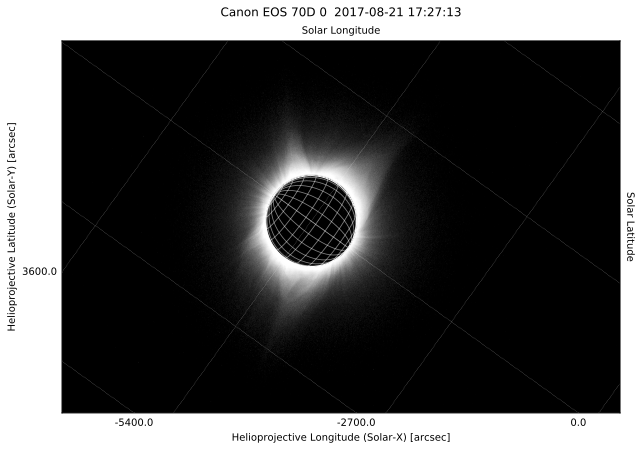

In [29]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.show()

# Overplot the location of Regulus

In [30]:
regulus = SkyCoord(ra='10h08m22.311s', dec='11d58m01.95s', distance=79.3 * u.lightyear, frame='icrs').transform_to(m.coordinate_frame)

In [31]:
regulus

<SkyCoord (Helioprojective: obstime=2017-08-21 17:27:13, rsun=695508000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21 17:27:13): (lon, lat, radius) in (deg, deg, m)
    ( 0.,  6.92815602,   1.51325216e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-4478.02801534,  1510.09937509,   7.50236078e+14)>

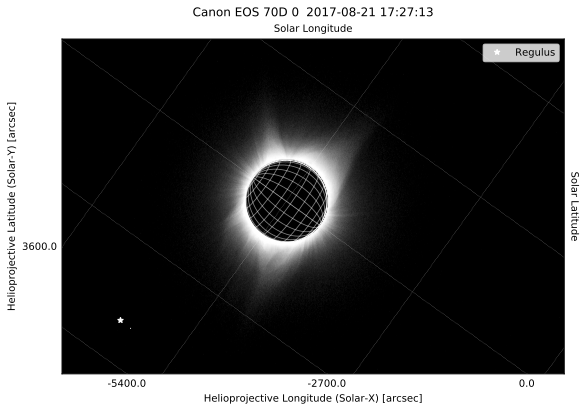

In [32]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(regulus, '*w', label='Regulus')
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.legend()
plt.show()

## Using Regulus to calculate image rotation

In this section we are going to use Regulus to work out a correction angle on our image to better align our coordinate system. To do this we will detect the location of Regulus in the image and compare it's actual position with the one calulated by assuming the camera was level with the horizon.

Firstly we calculate the expected pixel location of Regulus in our current coordinate system:

In [33]:
regulus_pixel = m.world_to_pixel(regulus)

Calculate the pixel distance of the expected location from the disk centre.

In [34]:
regulus_r = np.sqrt((regulus_pixel.x - im_cx)**2 + (regulus_pixel.y - im_cy)**2)
regulus_r

<Quantity [ 1119.94228407] pix>

Now calculate an array of pixel distance, that we will use to filter out the disk, for easier detection of Regulus.

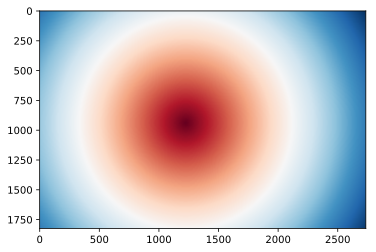

In [35]:
pix_x = np.arange((m.dimensions[0]).value) - im_cy.value
pix_y = np.arange((m.dimensions[1]).value) - im_cx.value
xx, yy = np.meshgrid(pix_x, pix_y)
r = np.sqrt(xx**2 + yy**2)
plt.imshow(r, cmap='RdBu')


We will now filter out the disk by removing everything inside a circle of just under the pixel distance of Regulus.

In [36]:
filter_r = regulus_r - (regulus_r/5)

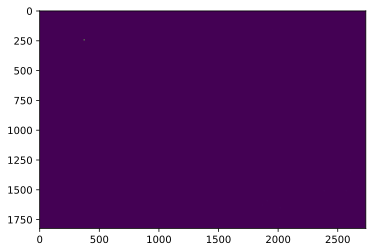

In [37]:
masked = im.copy()
masked[r < filter_r.value] = masked.min()
plt.imshow(masked)

Now we have an image with hopefully only Regulus in it, we can use the star finder rountine from phtoutils to find the pixel coordinates of Regulus in our image. As the image is basically empty we use the half max brightness as our threshold. (We assume that Regulus is the brightest point left).

In [38]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=masked.max()/2)    
sources = daofind(masked)    
print(sources)  

 id  xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------ ------------- ... ------------- ------------- --------------
  1 371.67556832 247.110905808 ... 222.666666667 2.01287960246 -0.75954449739


In [39]:
regulus_x, regulus_y = sources[0]['xcentroid'] * u.pix, sources[0]['ycentroid'] * u.pix

We can now compare the expected and actual locations of Regulus:

In [40]:
print(regulus_pixel.x, regulus_x)
print(regulus_pixel.y, regulus_y)

318.00754259193263 pix 371.675568319769 pix
291.32759917256146 pix 247.11090580785736 pix


We now use the dot product to calculate the rotation between the expected and actual location of Regulus. Note that the FITS convention angle is opposite in sign to the angle computed in pixel coordinates here.

In [41]:
vec_image = np.array([regulus_x - im_cx, regulus_y - im_cy]).T
vec_coord = np.array([regulus_pixel.x - im_cx, regulus_pixel.y - im_cy])
fudge_angle = np.arccos((vec_image @ vec_coord) / (np.linalg.norm(vec_image) * np.linalg.norm(vec_coord)))*u.rad
fudge_angle = fudge_angle.flat[0] * -1
fudge_angle.to(u.deg)

<Quantity -3.5139119453194705 deg>

We now use this angle as our fudge angle to better align the coordinate systems.

In [42]:
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, time) + fudge_angle
print(solar_rotation_angle.to(u.deg).value)
header.update({'CROTA2': solar_rotation_angle.to('deg').value})
m = sunpy.map.Map((im, header))

reg_dist = np.sqrt((regulus_pixel.x - regulus_x)**2 + (regulus_pixel.y-  regulus_y)**2)

while reg_dist.value > 0.5:    
    regulus_pixel = m.world_to_pixel(regulus)
    regulus_r = np.sqrt((regulus_pixel.x - im_cx)**2 + (regulus_pixel.y - im_cy)**2)
    regulus_r

    filter_r = regulus_r - (regulus_r/5)
    masked = im.copy()
    masked[r < filter_r.value] = masked.min()

    daofind = DAOStarFinder(fwhm=3.0, threshold=masked.max()/2)    
    sources = daofind(masked)    
    #print(sources)  

    regulus_x, regulus_y = sources[0]['xcentroid'] * u.pix, sources[0]['ycentroid'] * u.pix
    
    reg_dist = np.sqrt((regulus_pixel.x - regulus_x)**2 + (regulus_pixel.y-  regulus_y)**2)
    
    im_radius = im_radius - (0.01* u.pix)
    print(im_radius,reg_dist)    
    plate_scale = rsun_obs / im_radius 
    
#    print(plate_scale)
    
    header.update({'CDELT1': plate_scale.to('arcsec/pix').value[0]})
    header.update({'CDELT2': plate_scale.to('arcsec/pix').value[0]})

    #print(header)
    
    m = sunpy.map.Map((im, header))


-57.84283772198601
[ 222.99] pix 15.726935471359223 pix
[ 222.98] pix 15.677077690235993 pix
[ 222.97] pix 15.62721991022514 pix
[ 222.96] pix 15.577362131332432 pix
[ 222.95] pix 15.527504353568569 pix
[ 222.94] pix 15.47764657694428 pix
[ 222.93] pix 15.427788801470973 pix
[ 222.92] pix 15.377931027159413 pix
[ 222.91] pix 15.328073254021366 pix
[ 222.9] pix 15.27821548206846 pix
[ 222.89] pix 15.228357711311588 pix
[ 222.88] pix 15.17849994176314 pix
[ 222.87] pix 15.128642173434818 pix
[ 222.86] pix 15.078784406338707 pix
[ 222.85] pix 15.028926640487303 pix
[ 222.84] pix 14.979068875892745 pix
[ 222.83] pix 14.929211112568021 pix
[ 222.82] pix 14.87935335052529 pix
[ 222.81] pix 14.82949558977812 pix
[ 222.8] pix 14.779637830339308 pix
[ 222.79] pix 14.729780072222347 pix
[ 222.78] pix 14.679922315439978 pix
[ 222.77] pix 14.630064560007005 pix
[ 222.76] pix 14.580206805936463 pix
[ 222.75] pix 14.530349053242151 pix
[ 222.74] pix 14.480491301939285 pix
[ 222.73] pix 14.4306335520

[ 220.74] pix 4.509031441445448 pix
[ 220.73] pix 4.459175614999802 pix
[ 220.72] pix 4.409319836682826 pix
[ 220.71] pix 4.3594641081452625 pix
[ 220.7] pix 4.309608431115415 pix
[ 220.69] pix 4.259752807400708 pix
[ 220.68] pix 4.209897238896381 pix
[ 220.67] pix 4.160041727586678 pix
[ 220.66] pix 4.110186275553838 pix
[ 220.65] pix 4.060330884980332 pix
[ 220.64] pix 4.010475558158693 pix
[ 220.63] pix 3.960620297496325 pix
[ 220.62] pix 3.9107651055232875 pix
[ 220.61] pix 3.8609099849009487 pix
[ 220.6] pix 3.8110549384287733 pix
[ 220.59] pix 3.761199969056143 pix
[ 220.58] pix 3.7113450798897 pix
[ 220.57] pix 3.6614902742060838 pix
[ 220.56] pix 3.6116355554613584 pix
[ 220.55] pix 3.56178092730761 pix
[ 220.54] pix 3.511926393602441 pix
[ 220.53] pix 3.4620719584257613 pix
[ 220.52] pix 3.4122176260964094 pix
[ 220.51] pix 3.36236340118887 pix
[ 220.5] pix 3.3125092885541436 pix
[ 220.49] pix 3.262655293338143 pix
[ 220.48] pix 3.212801421007122 pix
[ 220.47] pix 3.1629476773

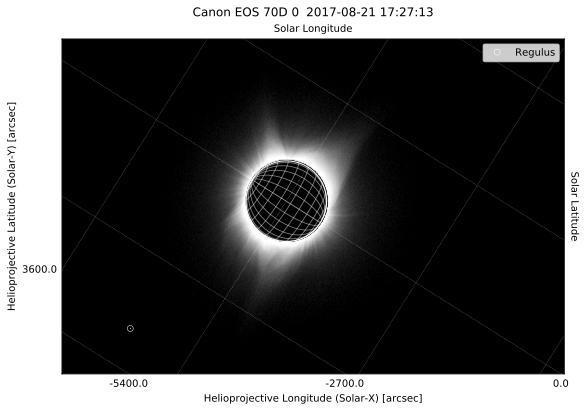

In [43]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(regulus, 'o', markeredgewidth=0.5, markeredgecolor='w', 
              markerfacecolor='None', label='Regulus')
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.legend()
plt.show()

More tweaking could be done here to get thing right. We will leave that as an exercise for the reader!

# Plot an SDO AIA Image of the Sun on your photo

First we need to download the images

In [44]:
from sunpy.net import Fido, attrs as a
# Replace the time below with the time in UT of the eclipse
t = a.Time('2017-08-21 17:27:13', "2017-08-21 17:45:13")
aia_result = Fido.search(t, a.Instrument('AIA'), a.Wavelength(171*u.Angstrom))
aia_result

<sunpy.net.fido_factory.UnifiedResponse object at 0x121f30b38>
Results from 1 Provider:

90 Results from the VSOClient:
   Start Time [1]       End Time [1]    Source ...   Type   Wavelength [2]
                                               ...             Angstrom   
       str19               str19         str3  ...   str8      float64    
------------------- ------------------- ------ ... -------- --------------
2017-08-21 17:27:21 2017-08-21 17:27:22    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:27:33 2017-08-21 17:27:34    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:27:45 2017-08-21 17:27:46    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:27:57 2017-08-21 17:27:58    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:28:09 2017-08-21 17:28:10    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:28:21 2017-08-21 17:28:22    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:28:33 2017-08-21 17:28:34    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:28:45 2017-08-21 17:28:46    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:28:57 2017-08-21 17:28:58    SDO ... FULLDISK 171.0 .. 171.0
                ...                 ...    ... ...      ...            ...
2017-08-21 17:43:21 2017-08-21 17:43:22    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:43:33 2017-08-21 17:43:34    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:43:45 2017-08-21 17:43:46    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:43:57 2017-08-21 17:43:58    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:44:09 2017-08-21 17:44:10    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:44:21 2017-08-21 17:44:22    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:44:33 2017-08-21 17:44:34    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:44:45 2017-08-21 17:44:46    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:44:57 2017-08-21 17:44:58    SDO ... FULLDISK 171.0 .. 171.0
2017-08-21 17:45:09 2017-08-21 17:45:10    SDO ... FULLDISK 171.0 .. 171.0

In [45]:
files = Fido.fetch(aia_result[0,0])

[                                        ======================

In [46]:
files

['/Users/oliveros/sunpy/data/aia_lev1_171a_2017_08_21t17_27_21_35z_image_lev1.26.fits']

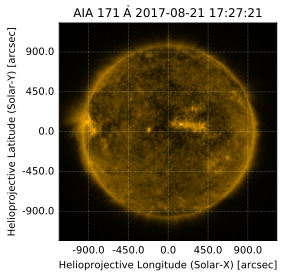

In [47]:
aia_map = sunpy.map.Map(files[0])
aia_map.plot()

To overplot the images we must align them, this can be done with `rotate`.

In [48]:
am2 = aia_map.rotate(rmatrix=np.linalg.inv(m.rotation_matrix),
                     recenter=True, order=3, scale=(aia_map.scale[0]/m.scale[0]))

/Users/oliveros/anaconda/lib/python3.6/site-packages/sunpy/image/transform.py:122: RuntimeWarning: Input data has been cast to float64
  warnings.warn("Input data has been cast to float64", RuntimeWarning)


We then must calculate the extent of the AIA image in terms of pixels in the eclipse image.

In [49]:
xmin, ymin = (u.Quantity(m.reference_pixel) - u.Quantity(am2.reference_pixel)).to_value(u.pix)

In [50]:
xmax = am2.data.shape[1] + xmin
ymax = am2.data.shape[0] + ymin

In [51]:
extent = (xmin, xmax, ymin, ymax)

Finally we mask out the pixels with a low value in the eclipse image (to make the disk transparent).

In [52]:
m.data[m.data < 30] = np.nan

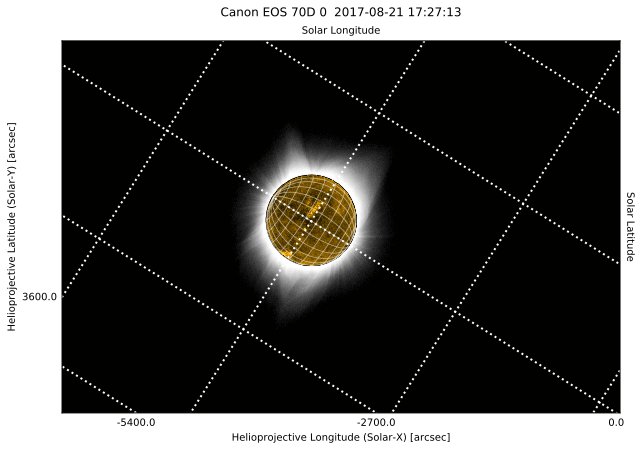

In [53]:
fig = plt.figure(figsize=(10,15))
ax = plt.subplot(projection=m)

# Set the axes background to black.
ax.set_facecolor('k')

# Plot the AIA image.
am2.plot(extent=extent)
# Plot the eclipse image
m.plot()

# Draw heliographic and helioprojective grids
m.draw_grid()
ax.coords.grid(color='white', alpha=1, linestyle='dotted',linewidth=2)